In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/Homework2/'

file1 = 'CRSPzero_yields.xls'
file2 = 'GDPC1.xls'
file3 = 'Factors(1).xlsx'
file4 = 'FoF.xlsx'
file5 = 'tbill.csv'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Code from: http://nbviewer.jupyter.org/gist/aflaxman/6871948
# randomly resamples Series and returns it
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = np.array(X[resample_i])  # TODO: write a test demonstrating why array() is important
    return X_resample


In [3]:
tbill=pd.read_csv(dir+file5,parse_dates=0,index_col=0).resample(rule='m',how='last')
factors=pd.read_excel(dir+file3,parse_dates=0,header=4,index_col=0).resample(rule='m',how='last')
FoF=pd.read_excel(dir+file4,parse_dates=0,index_col=0).resample(rule='m',how='last')

Since we use excess returns in the regression, we need to take away 30 day cash returns.

In [4]:
FoF=FoF-tbill.t30ret*100

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


To calculate $\alpha$ for each fund and it's relevent t-stat, I use the benhcmakr model of Fung and Hsieh (RFS, 2001):

$$ rexc_{i,t} = \alpha_i + \beta_i^1SNPexc_t+B_i^2SML_t+\beta_i^3MSCIem_t + \beta_i^4RBD10_t + \beta_+i^5BAAMBD10_t + \beta_i^6PTFSBD_t + \beta_i^7PTFSFX_t + \beta_i^8PTFSCOM_t + \varepsilon_{i,t} $$

I selected funds with only five years of fund performance in line with BSW for two reasons.  First to match exactly their procedure, but secondly because 5 years allows for the fund to see many different types of market environments.  I don't want to select funds just because they happen to launch at the right time.  Of the FoF list of 6392 names I only get 3101 with at least 5 yeras of data (continous or not).

In [5]:
beta=pd.DataFrame()
t_stats=pd.DataFrame()
p_values=pd.DataFrame()
r2= pd.Series()
for f in FoF.columns:
    df = pd.DataFrame()
    df['Fund']=FoF[f].dropna()
    if df.Fund.count() < 60:
        continue
    df=pd.concat([df,factors],axis=1, join='inner')
    df['Alpha']=1
    cols= factors.columns.tolist()
    cols.append('Alpha')
    res = sm.OLS(df.Fund,df[cols]).fit()
    beta[f]=res.params
    t_stats[f]=res.tvalues
    p_values[f]=res.pvalues
    r2[f]=res.rsquared

In [6]:
beta.T.mean()

Equity market factor       -3.441294
Size Spread factor          0.394232
Bond market factor         27.569260
Credit Spread factor     -189.273722
PTFSBD                     -0.390284
PTFSFX                      0.282721
PTFSCOM                     0.570708
Emerging Market factor     15.179668
Alpha                      -0.010674
dtype: float64

In [7]:
t_stats.T.mean()

Equity market factor     -0.551242
Size Spread factor        0.160711
Bond market factor        0.306786
Credit Spread factor     -2.291481
PTFSBD                   -0.432450
PTFSFX                    0.245363
PTFSCOM                   0.378847
Emerging Market factor    4.043323
Alpha                     0.606405
dtype: float64

# $\alpha$ and T stat distribution

Note how high some of the alpha terms are

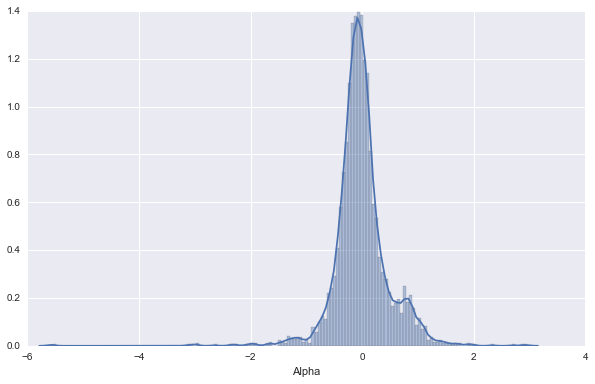

In [8]:
sns.distplot(beta.T.Alpha)

# Model

The model tries to understand a set of unknown parameters: $\theta = [ \pi_b, \pi_g,\alpha_b,\alpha_g, \beta_b, \beta_g, \delta_b, \delta,g]$.  Where:

$\pi$ is the percentage of funds with high and low (negative) alpha

$\alpha$ is the expected alpha for higher and lower buckets of funds 

$\beta$ is the fraction of the simulated t-ratios above a threshold t-ratio

$\delta$ is the confusion parameter is the fraction of funds below the lower threshold t-ratio where the fund is actually bucketed in the wrong catagory

The first issue is coming up with the size of the test, $\gamma/2$.

# Step 1
Create simulated data and find the values for $t_g$ and $t_b$ based on the $\gamma/2$, which we will use 10%.  

# Step 2
Percentage funds above $t_g$ is equal to $\beta_g$ and likewise for the bad funds.  But this is for $\alpha_g>0$.


In [57]:
gamma = 10
thres = stats.t.ppf(1-(gamma/200.),999)   
beta.T.Alpha.mean()+ beta.T.Alpha.std()*thres

0.79871591919409202

In [55]:
stats.ttest_1samp(beta.T.Alpha , 0)

(-1.2090566828297424, 0.22673327424977596)